#IMPORT# 기본 및 한글 설정

In [18]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 맑은 고딕 설정
plt.rc('font', family='Malgun Gothic')  # Windows
# plt.rc('font', family='AppleGothic')  # macOS
# plt.rc('font', family='NanumGothic')  # Linux (Colab 등에서)

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

#파일 Input#

In [19]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

#특성과 타겟 변수 분리
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

In [20]:
print(train.info())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   설립연도            4376 non-null   int64  
 1   국가              4376 non-null   object 
 2   분야              3519 non-null   object 
 3   투자단계            4376 non-null   object 
 4   직원 수            4202 non-null   float64
 5   인수여부            4376 non-null   object 
 6   상장여부            4376 non-null   object 
 7   고객수(백만명)        3056 non-null   float64
 8   총 투자금(억원)       4376 non-null   float64
 9   연매출(억원)         4376 non-null   float64
 10  SNS 팔로워 수(백만명)  4376 non-null   float64
 11  기업가치(백억원)       3156 non-null   object 
 12  성공확률            4376 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 444.6+ KB
None
              설립연도         직원 수     고객수(백만명)    총 투자금(억원)       연매출(억원)  \
count  4376.000000  4202.000000  3056.000000  4376.000000   4376.000000   

데이터 인풋 좋음
결측치 확인

,MissingCount,MissingRatio
고객수(백만명),1320,0.301645
기업가치(백억원),1220,0.278793
분야,857,0.195841
직원 수,174,0.039762
설립연도,0,0.000000
투자단계,0,0.000000
국가,0,0.000000
상장여부,0,0.000000
인수여부,0,0.000000
총 투자금(억원),0,0.000000


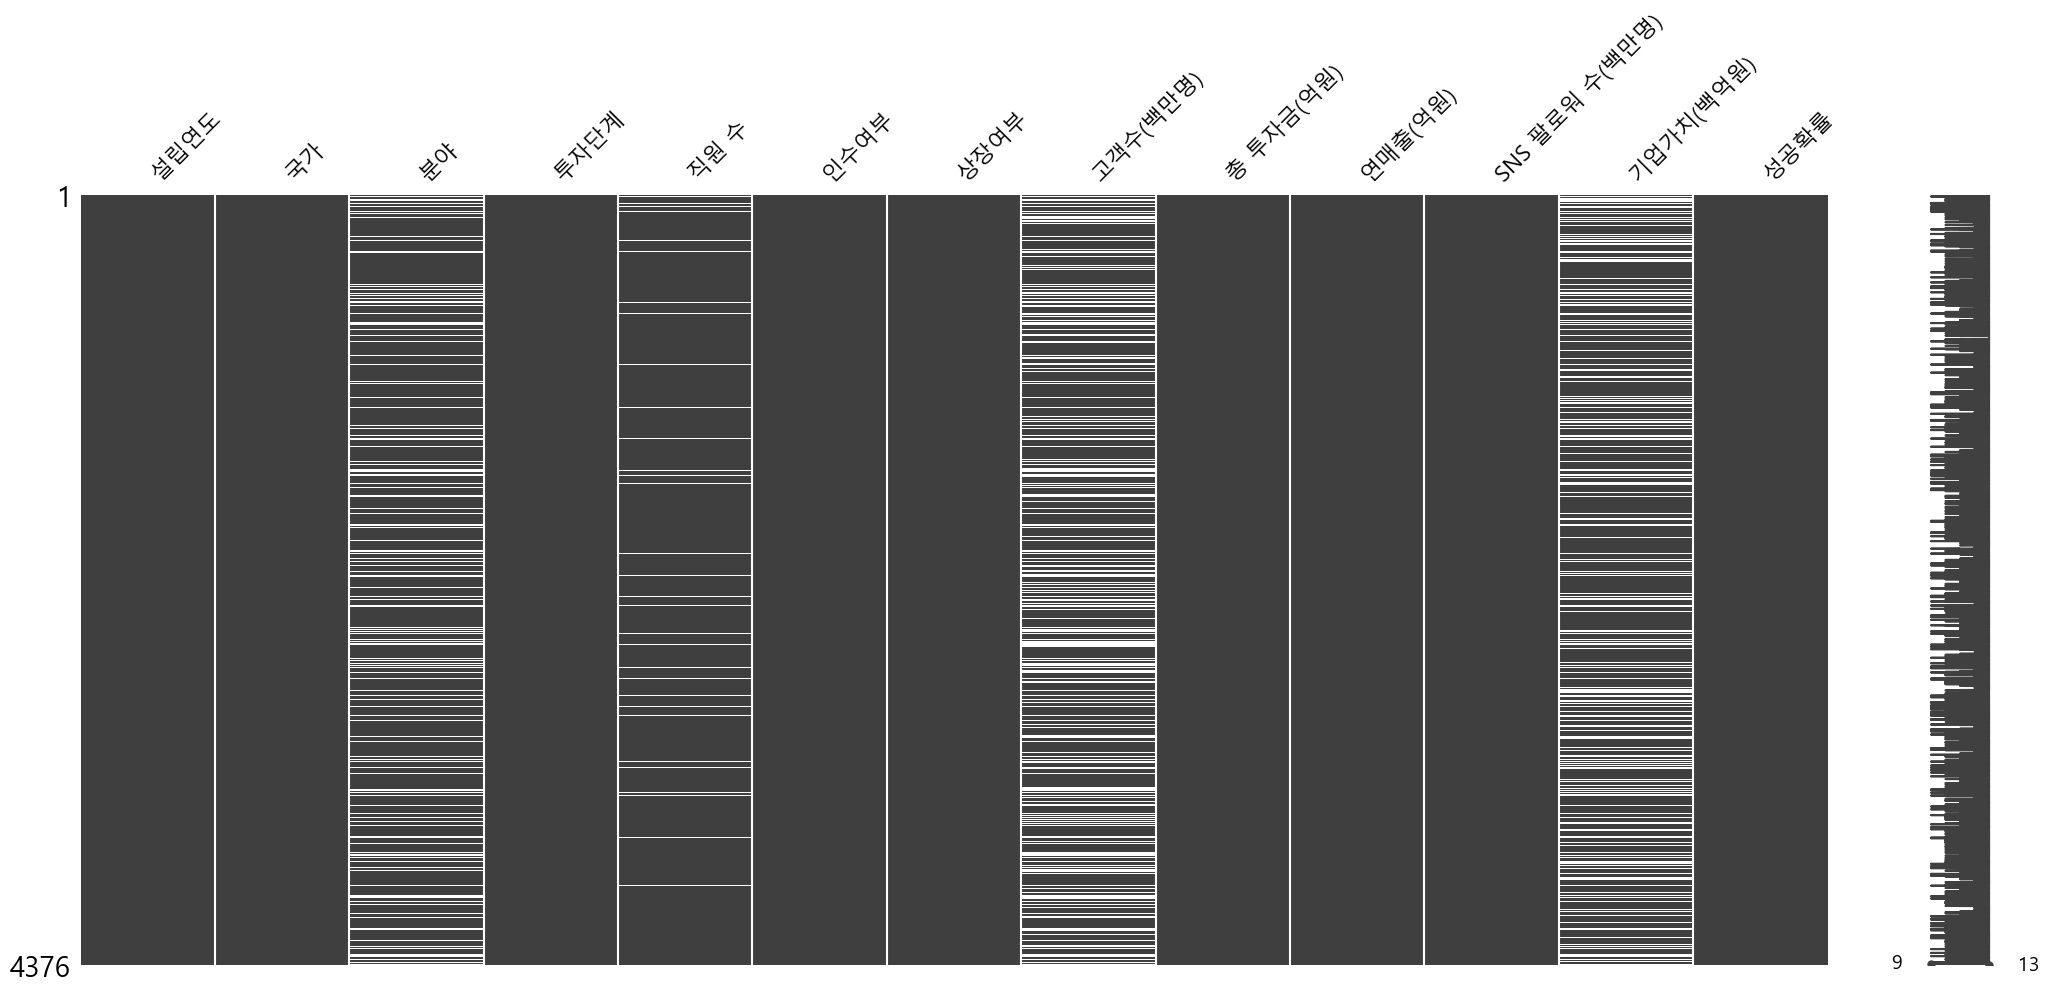

In [21]:
import missingno as msno
msno.matrix(train)  # 또는 msno.heatmap(train)
# 결측치 개수 확인
missing_counts = train.isnull().sum()

# 결측치 비율까지 함께 보기
missing_info = pd.DataFrame({
    "MissingCount": missing_counts,
    "MissingRatio": missing_counts / len(train)
}).sort_values(by="MissingRatio", ascending=False)

missing_info

결측이 많은 곳
범주형 : 분야
수치형 : 직원수, 고객수, 기업가치
------
일부컬럼은 동시에 결측(고객수, 기업가치, 직원수) --> 다변량 보간 or 모델 기반 보간

1. 범주형 먼저 처리
2. 수치형은 다변량 보간 or 결측 플래그

컬럼	    결측 수	    비율
고객수	    1,320	    30.2%       - 고객 수,직원 수, 연매출, 총 투자금, SNS 수..
기업가치	1,220	    27.9%       - 직원수, 분야, 연매출..
분야	    857         19.6%       - 예측보다 Unknown으로 대체 라벨 인코딩
직원 수	    174	        4.0%        - 설립연도, 국가, 투자단계, 연매출, 총 투자금..

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
# 기업가치(백억원) 숫자화
# 기업가치 컬럼도 범위 문자열 처리 추가

def convert_range_to_float(value):
    if isinstance(value, str) and '-' in value:
        try:
            low, high = map(float, value.split('-'))
            return (low + high) / 2
        except:
            return np.nan
    try:
        return float(value)
    except:
        return np.nan
    
def encode_categoricals(df, cols):
    df = df.copy()
    for col in cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def fill_missing_values_v3(df, is_train=True):
    df = df.copy()

    # 범위 문자열 → 평균 숫자 처리
    for col in ['연매출(억원)', '총 투자금(억원)', '기업가치(백억원)']:
        df[col] = df[col].apply(convert_range_to_float)

    # 분야 결측 및 인코딩
    if '분야' in df.columns:
        df['분야'] = df['분야'].fillna('Unknown')
        df['분야'] = LabelEncoder().fit_transform(df['분야'])

    # 국가, 투자단계 인코딩
    df = encode_categoricals(df, ['국가', '투자단계'])

    # ✅ 결측 플래그 추가 함수
    def add_missing_flag(column):
        flag_col = f'{column}_결측'
        df[flag_col] = df[column].isnull().astype(int)

    # ✅ 피처셋 생성 함수
    def get_features(base):
        return base + (['성공확률'] if is_train else [])

    # 1. 직원 수
    if '직원 수' in df.columns:
        add_missing_flag('직원 수')
        features = get_features(['설립연도', '국가', '투자단계', '연매출(억원)', '총 투자금(억원)', 'SNS 팔로워 수(백만명)'])
        complete = df[df['직원 수'].notnull()]
        missing = df[df['직원 수'].isnull()]
        if not complete.empty and not missing.empty:
            model = GradientBoostingRegressor()
            model.fit(complete[features], complete['직원 수'])
            df.loc[df['직원 수'].isnull(), '직원 수'] = model.predict(missing[features])

    # 2. 고객 수
    if '고객수(백만명)' in df.columns:
        add_missing_flag('고객수(백만명)')
        features = get_features(['설립연도', '직원 수', '분야', '연매출(억원)', '총 투자금(억원)', 'SNS 팔로워 수(백만명)'])
        complete = df[df['고객수(백만명)'].notnull()]
        missing = df[df['고객수(백만명)'].isnull()]
        if not complete.empty and not missing.empty:
            model = GradientBoostingRegressor()
            model.fit(complete[features], complete['고객수(백만명)'])
            df.loc[df['고객수(백만명)'].isnull(), '고객수(백만명)'] = model.predict(missing[features])

    # 3. 기업가치
    if '기업가치(백억원)' in df.columns:
        add_missing_flag('기업가치(백억원)')
        features = get_features(['설립연도', '직원 수', '고객수(백만명)', '분야', '연매출(억원)', '총 투자금(억원)', 'SNS 팔로워 수(백만명)'])
        complete = df[df['기업가치(백억원)'].notnull()]
        missing = df[df['기업가치(백억원)'].isnull()]
        if not complete.empty and not missing.empty:
            model = GradientBoostingRegressor()
            model.fit(complete[features], complete['기업가치(백억원)'])
            df.loc[df['기업가치(백억원)'].isnull(), '기업가치(백억원)'] = model.predict(missing[features])

    return df

# 최종 결측치 보간 시도
train_filled = fill_missing_values_v3(train, is_train=True)
train_filled.isnull().sum()  # 모든 결측치가 잘 채워졌는지 확인

test_filled = fill_missing_values_v3(test, is_train=False)
test_filled.isnull().sum()  # 모든 결측치가 잘 채워졌는지 확인




설립연도              0
국가                0
분야                0
투자단계              0
직원 수              0
인수여부              0
상장여부              0
고객수(백만명)          0
총 투자금(억원)         0
연매출(억원)           0
SNS 팔로워 수(백만명)    0
기업가치(백억원)         0
직원 수_결측           0
고객수(백만명)_결측       0
기업가치(백억원)_결측      0
dtype: int64

결측flag -> features engineering, 모델선택 및 학습

In [ ]:
print(train_filled.info())
print(train_filled.describe())

기업가치_결측: 평균 ~0.41 → 약 41% 결측 → 플래그 중요할 가능성 높음
인수여부, 상장여부를 Label Encoding 또는 불리언화
현재 object 타입이라 모델링 전에 처리 필요

결측 플래그와 기존 변수 간의 상관성 확인 (EDA)
예: 기업가치_결측 == 1인 기업은 성공확률이 낮은가?

Feature Importance 실험 시 플래그 포함한 버전과 아닌 버전 비교

Series([], dtype: object)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 4376, number of used features: 15
[LightGBM] [Info] Start training from score 0.537340


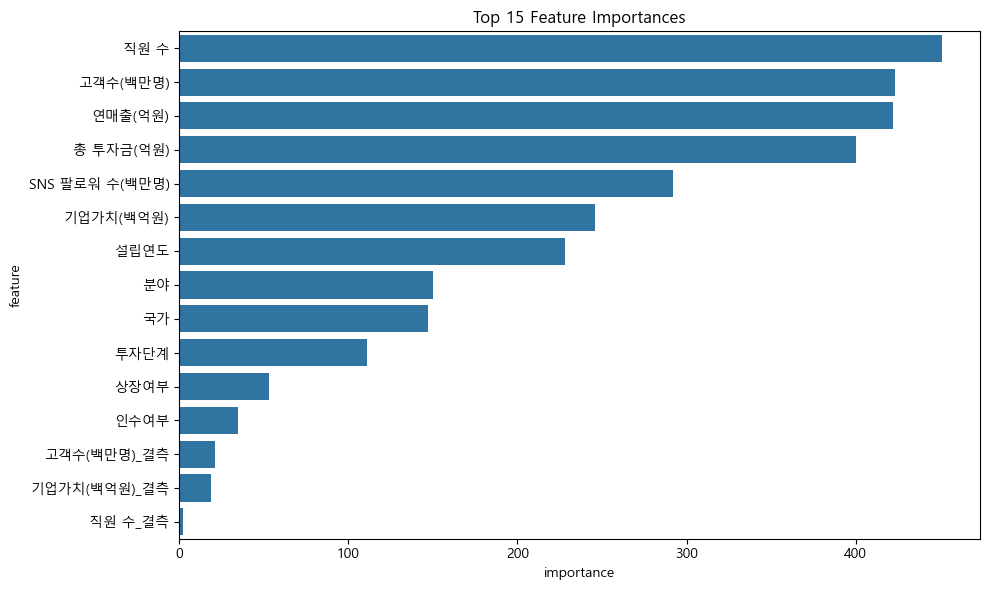

In [46]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 피처 및 타겟 설정
feature_cols = [col for col in train_filled.columns if col not in ['성공확률']]
target_col = '성공확률'

X = train_filled[feature_cols].copy()
y = train_filled[target_col].copy()

for col in X.select_dtypes(include='object').columns:
    if set(X[col].unique()) <= {'Yes', 'No'}:
        X[col] = X[col].map({'No': 0, 'Yes': 1})
print(X.dtypes[X.dtypes == 'object'])         
# 2. 모델 훈련
model = lgb.LGBMRegressor()
model.fit(X, y)

# 3. Feature Importance 추출
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# 4. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()


✅ 완료한 단계:
데이터 확인
→ train_filled 확인 및 결측치 보간 전략 수립

목표 확인
→ 회귀문제로서 '성공확률' 예측으로 명확히 설정됨

결측치 확인 및 처리
→ LightGBM, IterativeImputer, 중간값, 'Unknown' 등으로 처리 완료

EDA (시각화 포함한 탐색적 분석)
→ 부분적으로 진행 (feature importance 시각화 포함)

컬럼별 분석 + 이상치 탐색
→ 일부 진행됨 (분포 확인, 결측치 비율 등), 그러나 시각화 중심 이상치 탐색은 미완

데이터 라벨링 및 불리언화
→ 'Y/N' → 1/0 변환 완료

필요없는 컬럼 제거
→ '성공확률' 제외하고 모델링용 컬럼 구성 완료

Feature Engineering (파생변수 생성)
→ _결측 파생, 기존 변수 활용 등 일부 진행, 추가 확장 여지 있음

Feature Importance / 상관 분석
→ LGBM을 통한 Feature Importance 완료, 상관 분석은 미진행

🔜 다음 단계로 이어질 수 있는 건:
검증 전략 설정 (KFold 등)
→ 모델 평가 안정성을 위해 아직 필수로 필요

모델 선택 및 학습
→ 현재 LightGBM만 사용, TabNet, XGBoost 등 추가 가능

하이퍼파라미터 튜닝
→ 기본 파라미터로만 학습 → 아직 미완료

최종 모델 선정
→ 여러 모델 성능 비교 및 결정 필요

결과 예측 및 저장
→ Test 데이터에 대한 예측 저장은 아직 없음

평가 지표 확인 및 대회 제출
→ 평가 지표 확인/계산 및 제출 과정은 미진행

#이상치탐색
✅ 이상치 탐색 방법 요약

방법	설명	예시
IQR (사분위수 범위)	범위를 벗어나는 값을 이상치로 간주	수치형 데이터 전체에 적용 가능
Z-score / Standard score	평균에서 얼마나 떨어져 있는지 계산 (정규 분포 전제)	z > 3 or z < -3
Boxplot 시각화	시각적으로 극단값 확인	sns.boxplot
분포 시각화	histplot, kdeplot 등으로 확인	로그 변환도 병행
Isolation Forest / LOF	모델 기반 이상치 탐지 (고차원 가능)	많은 변수에서 적용 가능

['설립연도', '국가', '분야', '투자단계', '직원 수', '고객수(백만명)', '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '성공확률', '직원 수_결측', '고객수(백만명)_결측', '기업가치(백억원)_결측']


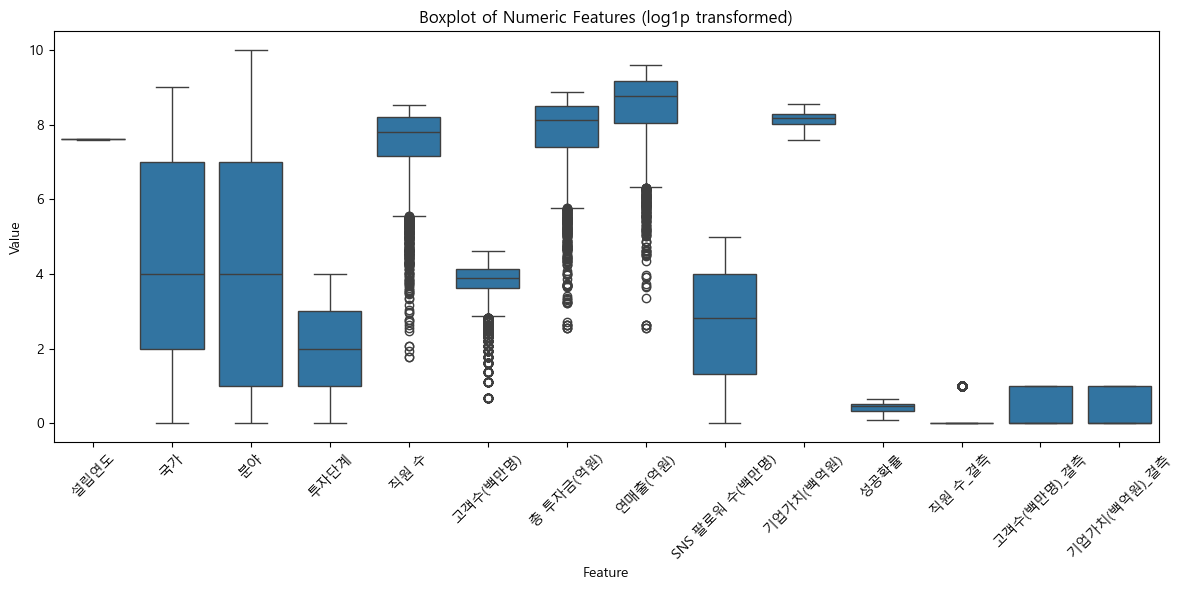

In [54]:
def detect_outliers_summary(df, columns):
    summary = []
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        summary.append({
            '컬럼명': col,
            '이상치 수': len(outliers),
            '전체 대비 비율(%)': round(len(outliers) / len(df) * 100, 2)
        })
    return pd.DataFrame(summary).sort_values(by='이상치 수', ascending=False)

# log 변환 (0보다 큰 값만 변환, log1p는 log(1+x))
num_cols = train_filled.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(num_cols)
log_train = train_filled[num_cols].copy()
for col in num_cols:
    if (log_train[col] > 0).all():  # 음수, 0 있는 컬럼은 제외
        log_train[col] = np.log1p(log_train[col])

# melt 후 시각화
melted_log = log_train.melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature', y='Value', data=melted_log)
plt.xticks(rotation=45)
plt.title('Boxplot of Numeric Features (log1p transformed)')
plt.tight_layout()
plt.show()


🔎 이상치가 눈에 띄는 변수
고객수(백만명), 총 투자금(원), 연매출(억원):
→ 모두 아래쪽과 위쪽에 많은 outlier 점들이 존재해. 특히 상위쪽에 몰려 있어서 일부 기업이 유독 수치가 크다는 걸 의미해.

**SNS 팔로워 수(백만명)**도 이상치가 없지는 않지만 상대적으로 덜함.

성공률, 직원 수, 기업가치(억원) 등의 결측치 기반 파생변수들(결측_)은 대부분 0, 1로 구성되어 있으므로 이상치 개념이 크게 적용되지 않음.

✅ 다음 행동 제안
이상치로 의심되는 지점들을 수치로 확인하고 싶다면, IQR 기준으로 상하위 극단값을 추출해볼 수 있어.

또는, 특정 변수(예: 연매출)에서 상위 1% 기업의 특성을 분석해보는 것도 좋은 인사이트를 줄 수 있어.

또 다른 방향으로는, 이상치를 별도로 처리한 파생변수를 만드는 것도 방법이야. 예:

연매출_이상치여부 (1: 이상치, 0: 정상)

총투자금_로그값 같은 스케일 조정형 파생변수

In [ ]:
import numpy as np
import pandas as pd

def process_outliers_train_test(train_df, test_df, num_cols, method='flag+clip'):
    """
    train 데이터 기준으로 IQR 이상치 탐지 기준을 잡고,
    train/test 모두 동일한 방식으로 이상치 처리하는 함수
    """
    train_processed = train_df.copy()
    test_processed = test_df.copy()
    outlier_bounds = {}

    for col in num_cols:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_bounds[col] = (lower, upper)

        # 이상치 플래그
        if 'flag' in method:
            train_processed[f'{col}_이상치여부'] = ((train_df[col] < lower) | (train_df[col] > upper)).astype(int)
            test_processed[f'{col}_이상치여부'] = ((test_df[col] < lower) | (test_df[col] > upper)).astype(int)

        # 클리핑
        if 'clip' in method:
            train_processed[col] = train_df[col].clip(lower, upper)
            test_processed[col] = test_df[col].clip(lower, upper)

        # 로그 변환
        if 'log' in method:
            if (train_processed[col] >= 0).all() and (test_processed[col] >= 0).all():
                train_processed[col] = np.log1p(train_processed[col])
                test_processed[col] = np.log1p(test_processed[col])
            else:
                print(f"[경고] {col}은 log1p 불가능 (음수 또는 0 포함)")

    return train_processed, test_processed, outlier_bounds

# '성공확률'은 train에만 있으므로 제외
num_cols = train_filled.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if col != '성공확률']

# 이상치 처리 수행
train_processed, test_processed, bounds = process_outliers_train_test(train_filled, test_filled, num_cols, method='flag+clip')

# 결과 확인: 일부 컬럼에 대해 이상치 여부 플래그 분포 출력
for col in ['연매출(억원)', '고객수(백만명)', 'SNS 팔로워 수(백만명)']:
    flag_col = f'{col}_이상치여부'
    if flag_col in train_processed.columns:
        print(f"▶ {flag_col} - 이상치 개수(train): {train_processed[flag_col].sum()}")

▶ 연매출(억원)_이상치여부 - 이상치 개수(train): 0
▶ 고객수(백만명)_이상치여부 - 이상치 개수(train): 0
▶ SNS 팔로워 수(백만명)_이상치여부 - 이상치 개수(train): 0


In [ ]:
# X에 필요한 컬럼들이 모두 있는지 확인
required_cols = ['직원 수', '연매출(억원)', '총 투자금(억원)', '고객수(백만명)', 
                 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '설립연도']

missing = [col for col in required_cols if col not in X.columns]
print("❗ 누락된 컬럼:", missing if missing else "없음 — 파생변수 생성 가능")

def create_features(df):
    df = df.copy()
    df['직원 수_로그'] = np.log1p(df['직원 수'])
    df['연매출_로그'] = np.log1p(df['연매출(억원)'])
    df['총 투자금_로그'] = np.log1p(df['총 투자금(억원)'])
    
    df['고객수_직원비'] = df['고객수(백만명)'] / (df['직원 수'] + 1)
    df['연매출_직원비'] = df['연매출(억원)'] / (df['직원 수'] + 1)
    df['투자대비매출'] = df['연매출(억원)'] / (df['총 투자금(억원)'] + 1)
    df['SNS당고객'] = df['고객수(백만명)'] / (df['SNS 팔로워 수(백만명)'] + 1)
    df['기업가치대비투자'] = df['기업가치(백억원)'] / (df['총 투자금(억원)'] + 1)

    df['설립년차'] = 2025 - df['설립연도']

    df['고객수_결측'] = df['고객수(백만명)'].isna().astype(int)
    df['직원 수_결측'] = df['직원 수'].isna().astype(int)
    
    return df

X = train_processed.copy()  # ← 여기서 train_processed에 이상치 플래그가 들어있어야 함
X = create_features(X)      # 파생변수 추가

outlier_flags = [col for col in X.columns if '이상치여부' in col]
print("📌 포함된 이상치 플래그 컬럼들:")
print(outlier_flags)

for col in outlier_flags:
    count = X[col].sum()
    print(f"{col} - 이상치 개수: {count}")

상관계수 분석

In [ ]:
# 연속형 변수 간 상관계수
num_cols = [
    '직원 수', '연매출(억원)', '총 투자금(억원)', '고객수(백만명)', 
    'SNS 팔로워 수(백만명)', '기업가치(백억원)', 
    '직원 수_로그', '연매출_로그', '총 투자금_로그', 
    '고객수_직원비', '연매출_직원비', '투자대비매출',
    'SNS당고객', '기업가치대비투자', '설립년차'
]
corr_matrix = X[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Selected Feature Correlation Heatmap")
plt.show()

 해석 포인트
✅ 강한 양의 상관관계 (r ≥ 0.8)
직원 수 ↔ 직원 수_로그 (0.88)

연매출(억원) ↔ 연매출_로그 (0.89)

총 투자금(억원) ↔ 총 투자금_로그 (0.88)

➥ 이건 로그 파생변수가 잘 작동하고 있다는 뜻이야. 다만, 너무 중복되므로 둘 중 하나만 사용할지 고려해도 좋아.

✅ 의미 있는 비율 변수들
연매출_직원비 ↔ 연매출_로그: 0.86

투자대비매출 ↔ 연매출_직원비: 0.79

➥ 비율 파생변수들이 실제 수치보다 더 유의미한 정보를 담고 있을 가능성 있음 → 모델 학습 시 기대됨!

🔵 음의 상관관계 (r ≤ -0.5)
SNS당고객 ↔ SNS 팔로워 수(백만명) (-0.62)

투자대비매출 ↔ 총 투자금_로그: (-0.50)

➥ SNS 규모가 클수록 고객 대비 비율은 떨어지는 구조, 그리고 투자금 많을수록 효율 떨어질 수도 있다는 반영

✅ 결론 및 다음 액션 제안
파생변수 잘 구성됨, 특히 비율 변수들이 핵심 정보를 잘 추출한 것 같아.

로그와 원본 변수가 너무 비슷한 경우는 VIF 다중공선성도 고려해서 둘 중 하나만 쓸지 판단해도 좋아.

설립년차는 거의 모든 변수랑 독립적이라 좋은 정보원이 될 수 있어.

불필요한 컬럼 제거

🔍 제거 기준 제안
중복 정보

로그 변환 전 원변수 vs. 로그 변환 후 변수 → 둘 다 쓸 필요는 없음

예: 직원 수 vs. 직원 수_로그

강한 다중공선성 (VIF가 높진 않지만 조정 여지는 있음)

비슷한 정보를 담은 파생 변수끼리 조정

예: 연매출(억원) vs. 연매출_로그 vs. 연매출_직원비

정보 부족 / 영향 미미

시각화, 모델 성능 실험상 기여도 낮은 변수


✅ 유지 추천 컬럼

컬럼명	유지 이유
직원 수_로그	스케일 조정된 수치형 변수로, 직원 수보다 분포가 안정적
연매출_로그	고분산 완화용 변환 변수로 연매출(억원)보다 모델에 유리
총 투자금_로그	마찬가지로 분포 안정화에 도움, 원변수 제거 가능
고객수_직원비	조직 효율성(1인당 고객 수)을 나타냄
연매출_직원비	노동 생산성 지표로 해석 가능
투자대비매출	자본 효율성 비율, 핵심 비즈니스 성과 지표
SNS당고객	브랜드 파워나 인지도 관련 변수 가능성
기업가치대비투자	투자 효율성 (투자 대비 기업가치) 비교용
설립년차	시간에 따른 성장/안정성 측정 가능 변수
기업가치(백억원)	타깃과 관계 높을 수 있는 핵심 재무 지표
🔻 제거 추천 컬럼

컬럼명	제거 이유
직원 수	직원 수_로그, 직원비 계열 파생변수로 충분히 대체 가능
연매출(억원)	로그 및 비율 파생변수가 대체 가능하며, 그대로 두면 중복 정보
총 투자금(억원)	마찬가지로 로그 및 파생변수로 대체 가능
직원 수_결측, 고객수_결측	결측치 보간을 마쳤고, 이상치 플래그로 대체되었을 가능성 높음
(보간 전 플래그라면 유지 고려 가능)
⚠️ 보류 또는 확인 필요

컬럼명	설명
기업가치(백억원)_결측_이상치여부 등 플래그 변수들	모델 성능 기여도 실험 후 유지/제거 결정 필요
SNS 팔로워 수(백만명)	SNS당고객과 중복 가능성 있지만 원변수 자체의 예측력 확인 후 결정

In [ ]:
cols_to_drop = [
    '직원 수', '연매출(억원)', '총 투자금(억원)',
    '직원 수_결측', '고객수_결측', '설립연도'
]

existing_cols_to_drop = [col for col in cols_to_drop if col in X.columns]
X = X.drop(columns=existing_cols_to_drop)
print(X.columns.tolist())
y = train_processed['성공확률']  # 또는 별도로 보관해둔 y 사용
X = X.drop(columns=['성공확률'])

X_with_y = X.join(y.rename("성공확률"))
cor_target = X_with_y.corr()['성공확률'].sort_values(key=abs, ascending=False)
print(cor_target.head(15))


['국가', '분야', '투자단계', '인수여부', '상장여부', '고객수(백만명)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '고객수(백만명)_결측', '기업가치(백억원)_결측', '설립연도_이상치여부', '국가_이상치여부', '분야_이상치여부', '투자단계_이상치여부', '직원 수_이상치여부', '고객수(백만명)_이상치여부', '총 투자금(억원)_이상치여부', '연매출(억원)_이상치여부', 'SNS 팔로워 수(백만명)_이상치여부', '기업가치(백억원)_이상치여부', '직원 수_결측_이상치여부', '고객수(백만명)_결측_이상치여부', '기업가치(백억원)_결측_이상치여부', '직원 수_로그', '연매출_로그', '총 투자금_로그', '고객수_직원비', '연매출_직원비', '투자대비매출', 'SNS당고객', '기업가치대비투자', '설립년차']


KeyError: '성공확률'